In [1]:
import sys
sys.path.append('../')

from src.data_manager import DataManager
from src.embeddings_matcher import EmbeddingsMatcher
from src.utils import print_recommendations
from src.jsearch_scraper import JSearchScraper
from config import SEARCH_QUERIES
import json

In [2]:
# Charger les profils malgaches
with open('../data/madagascar_profiles.json', 'r', encoding='utf-8') as f:
    madagascar_profiles = json.load(f)['profiles']

print(f"✓ {len(madagascar_profiles)} profils malgaches chargés")
for p in madagascar_profiles:
    print(f"  - {p['name']} ({', '.join(p['skills'][:2])}...)")

✓ 5 profils malgaches chargés
  - Rakoto Jean (Python, Django...)
  - Nathalie Andrianampoinimerina (React, JavaScript...)
  - Michel Rakotondramasy (Java, Spring Boot...)
  - Sophie Rasoloarison (Data Analysis, Python...)
  - Luc Razafindraibe (DevOps, Docker...)


In [3]:
print("🔍 Scraping des offres pour Madagascar...")

scraper = JSearchScraper()

# Scraper toutes les recherches
for search in SEARCH_QUERIES:
    scraper.search_jobs(search['query'], search['location'], pages=1)

print(f"\n✓ {len(scraper.get_jobs())} offres collectées")
scraper.get_stats()

# Sauvegarder
scraper.save_to_json('../data/madagascar_jobs.json')

🔍 Scraping des offres pour Madagascar...

🔍 Recherche: Python developer - Antananarivo, Madagascar
   Page 1: 10 offres trouvées

🔍 Recherche: Python developer - Fianarantsoa, Madagascar
   Page 1: 10 offres trouvées

🔍 Recherche: Python developer - Toliara, Madagascar
   Page 1: 10 offres trouvées

🔍 Recherche: Data scientist - Antananarivo, Madagascar
   Page 1: 10 offres trouvées

🔍 Recherche: Data scientist - Fianarantsoa, Madagascar
   Page 1: 10 offres trouvées

🔍 Recherche: Machine learning - Madagascar
   Page 1: 10 offres trouvées

✓ 60 offres collectées

STATISTIQUES DU SCRAPING
Total offres scrappées: 31
Erreurs: 0

Top 5 entreprises:
  - Marriott International: 1 offres
  - KATMAI: 1 offres
  - Mindlance: 1 offres
  - Jobs via Dice: 1 offres
  - Progression Inc: 1 offres

Top 5 localisations:
  - Washington, DC: 12 offres
  - McLean, VA: 7 offres
  - Bethesda, MD: 4 offres
  - Arlington, VA: 4 offres
  - Alexandria, VA: 2 offres

✓ 31 offres sauvegardées dans ../data/madaga

In [4]:
# Charger les données
dm = DataManager()
dm.profiles = madagascar_profiles
dm.load_scraped_jobs('../data/madagascar_jobs.json')

print(f"✓ {len(dm.profiles)} profils")
print(f"✓ {len(dm.jobs)} offres")

✓ 31 offres scrappées chargées
✓ 5 profils
✓ 31 offres


In [5]:
# Entraîner le modèle avec les données malgaches
matcher = EmbeddingsMatcher(model_type="word2vec")
matcher.train_model(dm.profiles, dm.jobs)

print("✓ Modèle entraîné sur les données malgaches!")

📚 Entraînement du modèle WORD2VEC...
   Documents traités: 36
   Modèle entraîné! Vocabulaire: 1573 mots
✓ Modèle entraîné sur les données malgaches!


In [6]:
# Générer les recommandations pour chaque profil
all_recommendations = {}

for profile in dm.profiles:
    recommendations = matcher.recommend(profile, dm.jobs)
    all_recommendations[profile['id']] = recommendations
    print_recommendations(profile['name'], recommendations)


Recommandations pour Rakoto Jean

1. Staff Machine Learning EngineerNew Washington, DC - Remote - Angie's List
   Location: Washington, DC
   Salary: None - None
   Score de match: 99.97%
   URL: https://www.tealhq.com/job/staff-machine-learning-engineer-new-washington-dc-remote_b91ac995-fb18-4f48-ad93-f246bea3b738?utm_campaign=google_jobs_apply&utm_source=google_jobs_apply&utm_medium=organic

2. Python AI/ML Developer - Mindlance
   Location: Washington, DC
   Salary: None - None
   Score de match: 99.97%
   URL: https://jobright.ai/jobs/info/68eea001d078b81ad160cc95?utm_campaign=google_jobs_apply&utm_source=google_jobs_apply&utm_medium=organic

3. Python Developer with Java & Testing-5 - Realign LLC
   Location: McLean, VA
   Salary: None - None
   Score de match: 99.97%
   URL: https://www.indeed.com/viewjob?jk=dffd715be18af849&utm_campaign=google_jobs_apply&utm_source=google_jobs_apply&utm_medium=organic

4. Machine Learning Engineer - Medical NLP - Newwave Telecom & Technologies


📊 STATISTIQUES DES RECOMMANDATIONS MADAGASCAR
Total recommandations: 25
Score moyen: 99.98%
Score min: 99.97%
Score max: 99.99%


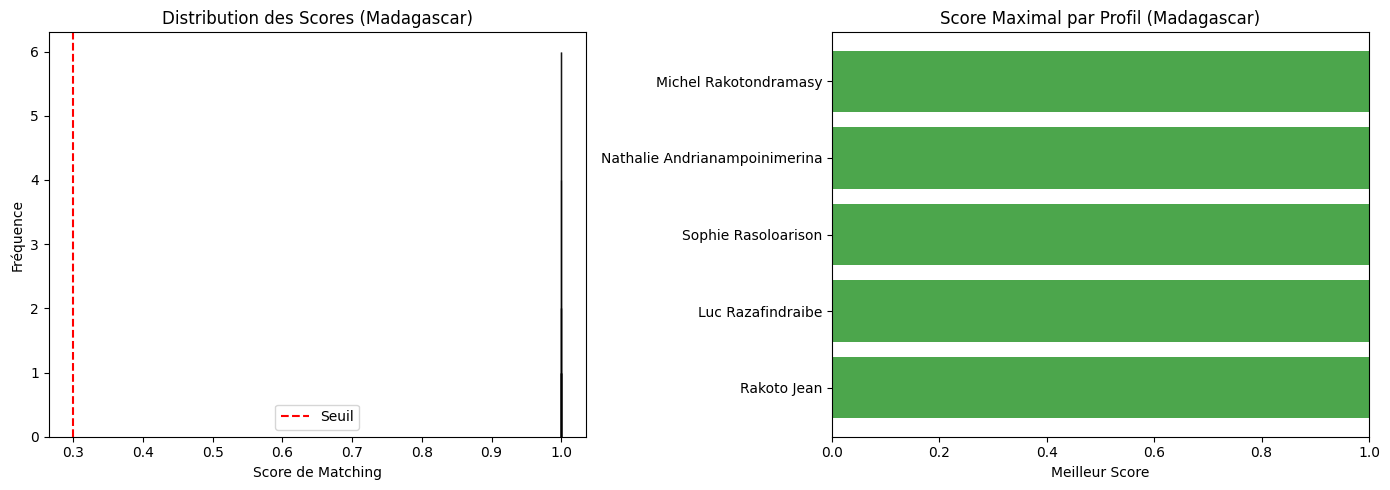

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Collecter les scores
all_results = []
for profile in dm.profiles:
    recommendations = all_recommendations[profile['id']]
    for rec in recommendations:
        all_results.append({
            'profile': profile['name'],
            'job': rec['job_title'],
            'company': rec['company'],
            'score': rec['score']
        })

df = pd.DataFrame(all_results)

print("📊 STATISTIQUES DES RECOMMANDATIONS MADAGASCAR")
print("="*70)
print(f"Total recommandations: {len(df)}")
print(f"Score moyen: {df['score'].mean():.2%}")
print(f"Score min: {df['score'].min():.2%}")
print(f"Score max: {df['score'].max():.2%}")

# Visualiser
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Distribution des scores
ax1 = axes[0]
ax1.hist(df['score'], bins=15, color='green', alpha=0.7, edgecolor='black')
ax1.set_xlabel('Score de Matching')
ax1.set_ylabel('Fréquence')
ax1.set_title('Distribution des Scores (Madagascar)')
ax1.axvline(x=0.3, color='red', linestyle='--', label='Seuil')
ax1.legend()

# Scores par profil
ax2 = axes[1]
profile_scores = df.groupby('profile')['score'].max().sort_values()
ax2.barh(profile_scores.index, profile_scores.values, color='green', alpha=0.7)
ax2.set_xlabel('Meilleur Score')
ax2.set_title('Score Maximal par Profil (Madagascar)')
ax2.set_xlim(0, 1)

plt.tight_layout()
plt.show()

In [10]:
# Exporter pour Phase 4
# Sauvegarder les profils et offres malgaches pour Phase 4
import json

with open('../data/madagascar_profiles.json', 'w', encoding='utf-8') as f:
    json.dump({'profiles': dm.profiles}, f, ensure_ascii=False, indent=2)

print("✓ Données malgaches sauvegardées pour Phase 4")

✓ Données malgaches sauvegardées pour Phase 4
